In [1]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.optimize import fsolve
from graph import *
from tqdm import tqdm

docs by names (62, 108) 108
docs by names (111, 108) 108


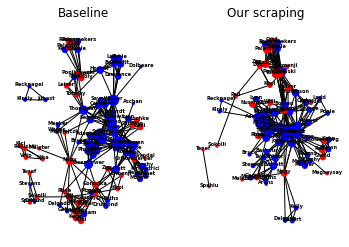

<Figure size 432x288 with 0 Axes>

Intersection, length:  172
barnes->savage
koch->palasthy
ponikiewski->tormay
dulles->joyce
hier->tormay
bohlen->joyce
dosti->kupi
conant->stassen
eisenhower->stassen
dulles->mathews
gellert->nagy
leiser->thompson
dulles->smith
dulles->stassen
ermenji->kupi
joyce->kohler
adenauer->morgan
barnes->kennan
jackson->kyes
barrett->dulles
conant->smith
barnes->thompson
savage->thompson
pali->sokolli
kennan->savage
koch->popa
ladd->wisner
brown->dulles
hier->leiser
delgado->nagy
hoover->poole
koch->konkoly
smith->stein
dulles->murphy
joyce->reinhardt
savage->wisner
palasthy->popa
jackson->stein
jackson->phillips
leiser->tormay
bross->dulles
dosti->pali
barbour->kohler
rademaekers->steele
kennan->thompson
spahiu->tenef
carter->savage
smith->stassen
hoover->ladd
conant->dulles
meyer->murphy
kyes->morgan
morgan->phillips
adenauer->conant
jackson->smith
gomulka->griffiths
barrett->gomulka
barbour->barrett
kennan->wisner
joyce->kennan
lyon->nuschke
meyer->morner
bohlen->wisner
kyes->stassen
joyce->s

In [41]:
# %load graph.py
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sys

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
np.set_printoptions(threshold=sys.maxsize)

def getfreqmatrix(filename):
    df = pd.read_csv(filename)
    names = list(df.columns)[1:]
    rownames = list(df["id"])  
    mydata = genfromtxt(filename, delimiter=',')
    mydata = mydata[1:,1:]
    return (names, rownames, mydata)


# M is a frequency matrix rows=documents, columns=names
def make_adjacency_matrix(M, names):
    n = len(names)
    print("docs by names", M.shape, n)
    A = np.zeros(n * n).reshape((n,n))
    for doc in M:
        for i in range(n):
            if doc[i] != 0:
                for j in range(i+1, len(doc)):
                    if doc[j] != 0:
                        A[i][j] += 1
                        A[j][i] += 1
    return A

# graph from adjacency matrix names by names
def nx_graph_from_adjacency_matrix(M, names, df, fig):
    V = names

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(V, nodetype="green")

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (V[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # formatting
    # pos = nx.random_layout(G, seed=490)
    pos = nx.spring_layout(G, seed=101, k=0.3, iterations=35)
    # remove isolated nodes
    deg = G.degree()
    to_remove = [n[0] for n in deg if n[1] == 0]
    G.remove_nodes_from(to_remove)

    #colors = [float(G.degree(n)) for n in G]
    sizes = [float(G.degree(n))*5 for n in G] 
    labels = {}
    for n in G.nodes():
        if G.degree(n) > 0:
            s = n[0].upper() + n[1:]
            labels[n] = s

    colors = []
    for n in G:
        r = df.loc[df["lastname"].str.lower() == n]
        if r.iloc[0]['affiliation'] == "west":
            colors.append("blue")
        elif r.iloc[0]['affiliation'] == "east":
            colors.append("red")
        else:
            colors.append("grey")
        pass

    nx.draw(G, pos=pos, node_color=colors, node_size=sizes, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels, font_size=5, 
            font_weight="bold", verticalalignment="bottom")
    f = plt.figure(fig)
    return (G, f)

# Adjust appearance of the nodes, edges, labels, etc.
def adjust_appearance_bipartite(G, pos):
    # Shift labels up off of their node
    textPos = pos.copy()
    for k in textPos:
        textPos[k][1] += .01

    labels = {}    
    for n in G.nodes():
        # Dont label documents, and only label figures with
        # a decently high degree 
        if ".txt" not in n and G.degree(n) > 2:
            s = n[0].upper() + n[1:]
            labels[n] = s
    nx.draw_networkx_labels(G, textPos, labels, font_size=10,  font_weight="bold",
                            verticalalignment="bottom")


# makes bipartite graph from documents to people
def nx_graph_from_biadjacency_matrix(M, txtfiles, names):

    U = txtfiles
    V = names

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0, nodetype="doc", nodesize=200, nodelabel=False)
    G.add_nodes_from(V, bipartite=1, nodetype="person", nodesize=50, nodelabel=True)

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (U[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # remove isolated nodes
    deg = G.degree()
    to_remove = [n[0] for n in deg if n[1] == 0]
    G.remove_nodes_from(to_remove)

    # Sets the colors of the nodes
    types= G.nodes(data="nodetype")
    print(types)
    colors = []
    for elm in types:
        print(elm)
        (n, typ) = elm
        degree = G.degree(n)
        if typ == "person":
            colors.append(float(degree))
        else:
            colors.append(-10.0)
    
    # formatting
    #colors = [float(G.degree(n)) for n in G]
    sizes = [u[1] for u in G.nodes(data="nodesize")]
    pos = nx.spring_layout(G, seed=101, k=0.1, iterations=15)
    nx.draw(G, pos=pos, node_size = sizes, with_labels=False, node_color = colors, edgecolors='black')

    adjust_appearance_bipartite(G, pos)

    plt.show()
    return G


# given set of edges, print them nicely
def format_edges(edges):
    for edge in list(edges):
        (n1, n2) = edge
        print(n1 + "->" + n2)

# given two graphs, returns jaccard index
def get_jaccard_index(G, H):
    A = set(G.edges)
    B = set(H.edges)
    n11 = A.intersection(B)   
    n10 = A.difference(B)
    n01 = B.difference(A)
    print("Intersection, length: ", len(n11))
    format_edges(n11)
    print("\n In our graph, not in baseline, length:", len(n10))
    format_edges(n10)
    print("\n In baseline, not in our Graph, length:", len(n01))
    format_edges(n01)
    return len(n11) / (len(n11) + len(n01) + len(n10))

def get_scraped_graph():
    namesdf = pd.read_csv("names.csv")
    (names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
    basemat = make_adjacency_matrix(basedata, names)
    (baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 2)
    return (baseG, basef)

if __name__ == "__main__":
    namesdf = pd.read_csv("names.csv")

    plt.subplot(1, 2, 1)
    (names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
    basemat = make_adjacency_matrix(basedata, names)
    (baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 1)
    plt.title('Baseline')
    

    plt.subplot(1, 2, 2)
    plt.title('Our scraping')
    (names, txtfiles, mydata) = getfreqmatrix("frequency.csv")  
    A = make_adjacency_matrix(mydata, names)
    (G, f1) = nx_graph_from_adjacency_matrix(A, names, namesdf, 2)
    # nx_graph_from_biadjacency_matrix(mydata, txtfiles, names)

    plt.show()

    J = get_jaccard_index(G, baseG)
    print("Jaccard index: ", J)

docs by names (62, 108) 108


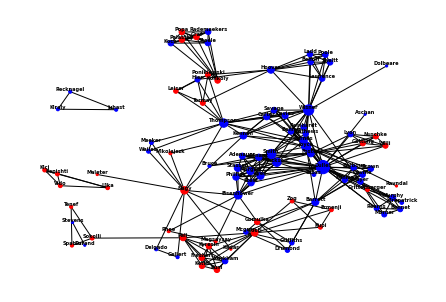

In [42]:
(names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
basemat = make_adjacency_matrix(basedata, names)
(baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 1)

In [44]:
import pysbm
import networkx as nx
import matplotlib.pylab as pl

In [83]:
graph = baseG

standard_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=2)
degree_corrected_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=2,
    representation=standard_partition.get_representation())
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=False)
degree_corrected_objective_function = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False)

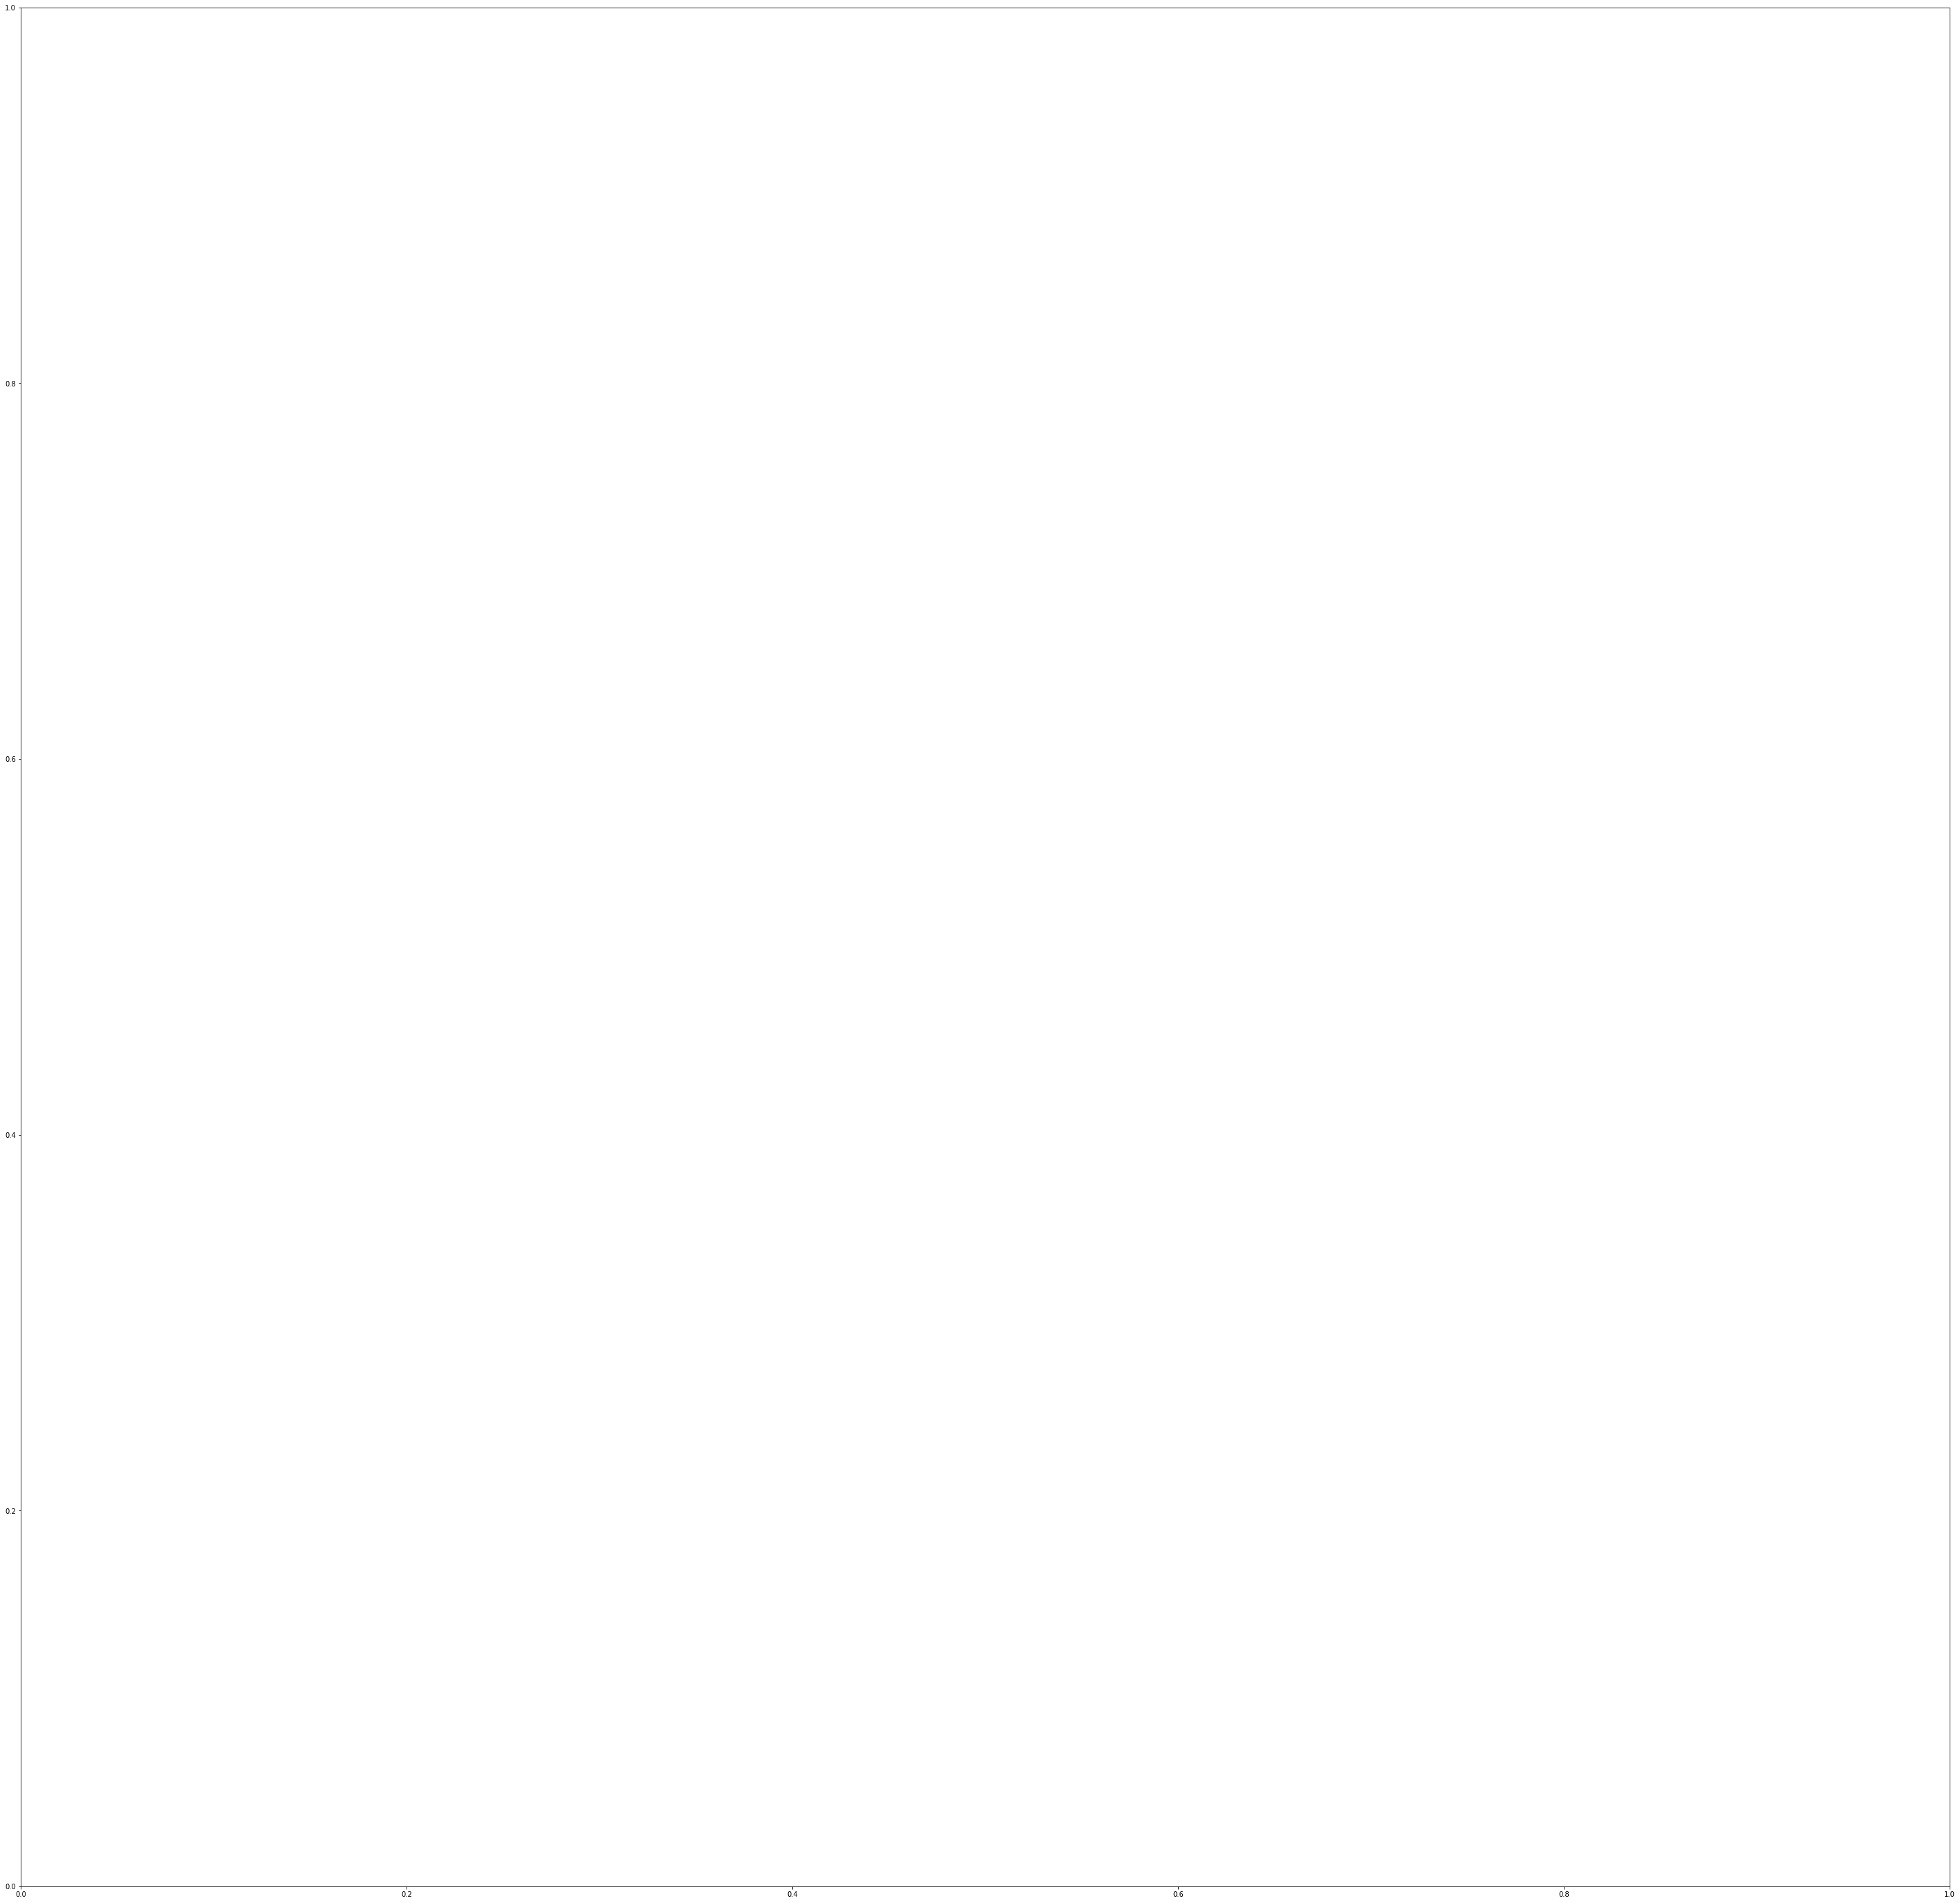

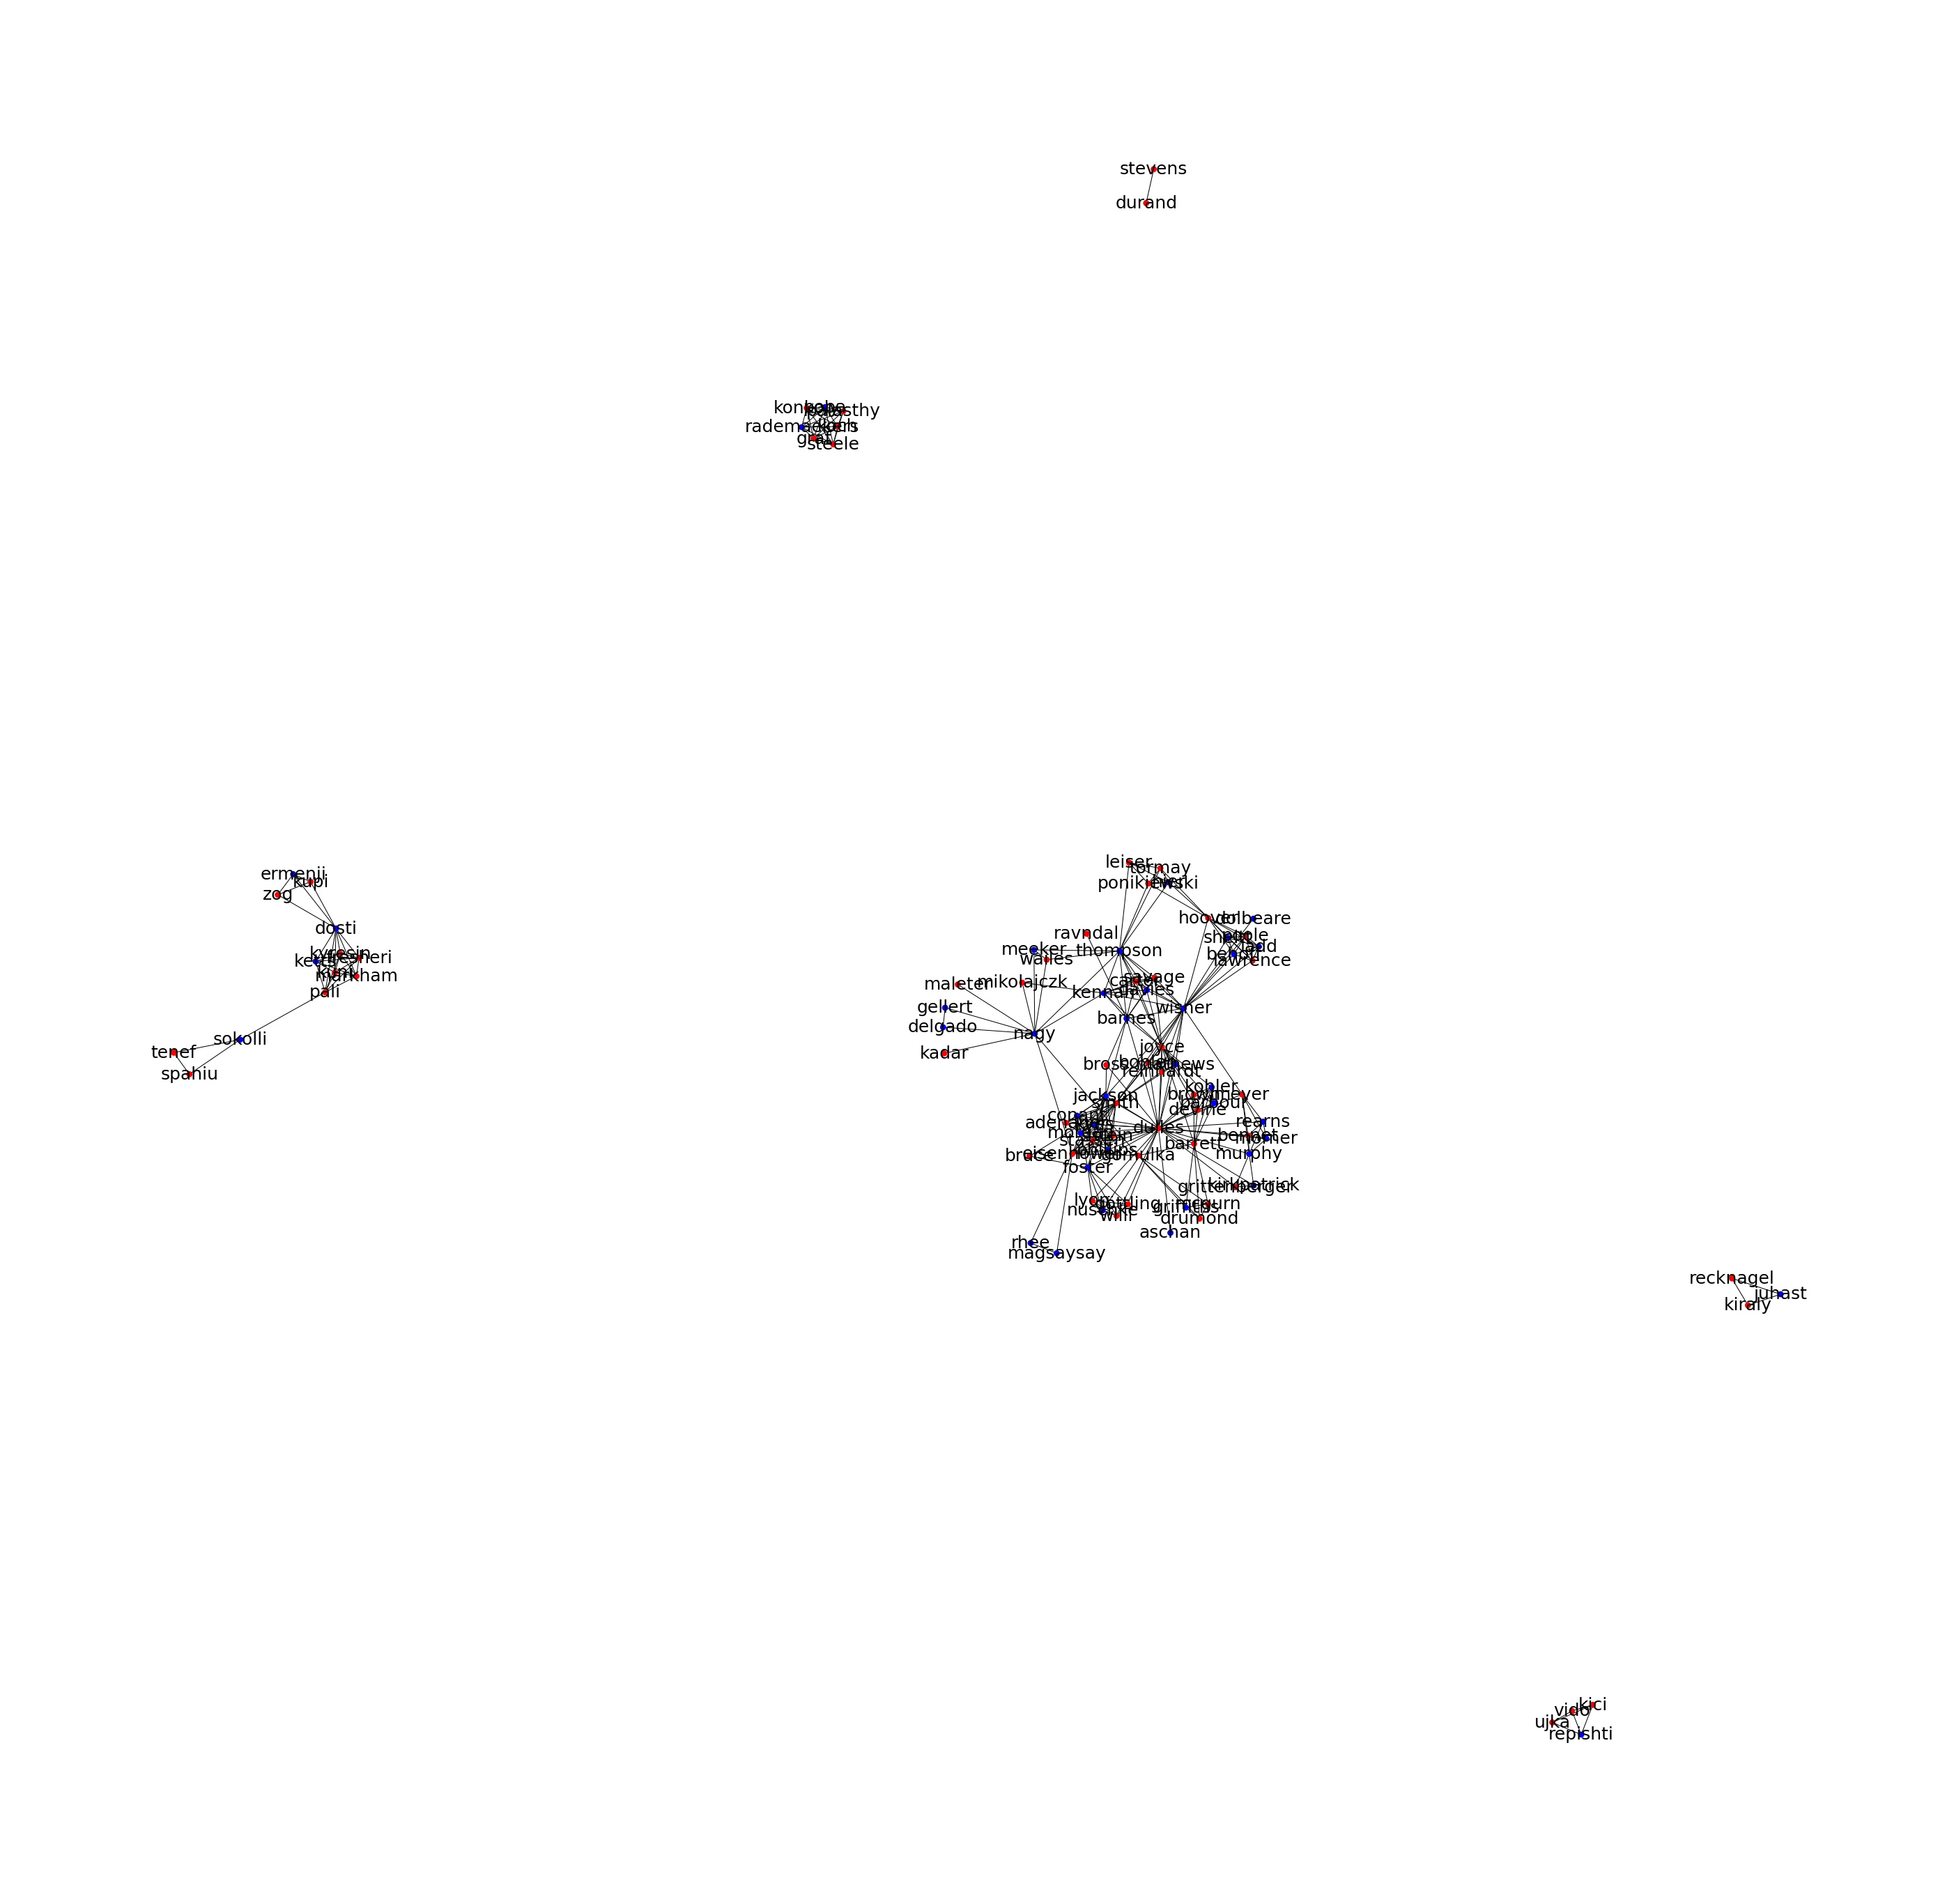

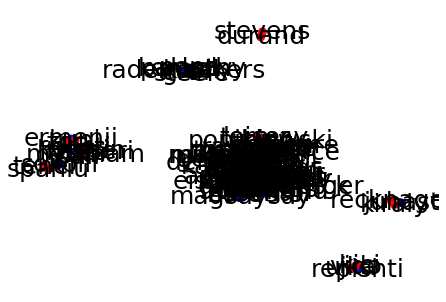

In [89]:
fig, ax = plt.subplots(figsize=(50,50))
nx.draw(graph, position, with_labels = True, node_size=60, font_size=25, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()
nx.draw(graph, position, with_labels = True, node_size=60, font_size=25, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()

In [70]:
standard_inference = pysbm.MetropolisHastingInference(graph, standard_objective_function, standard_partition)
degree_corrected_inference = pysbm.MetropolisHastingInference(graph, degree_corrected_objective_function, degree_corrected_partition)

In [71]:
standard_inference.infer_stochastic_block_model()
degree_corrected_inference.infer_stochastic_block_model()

Standard SBM with the splitting into high and low degree nodes


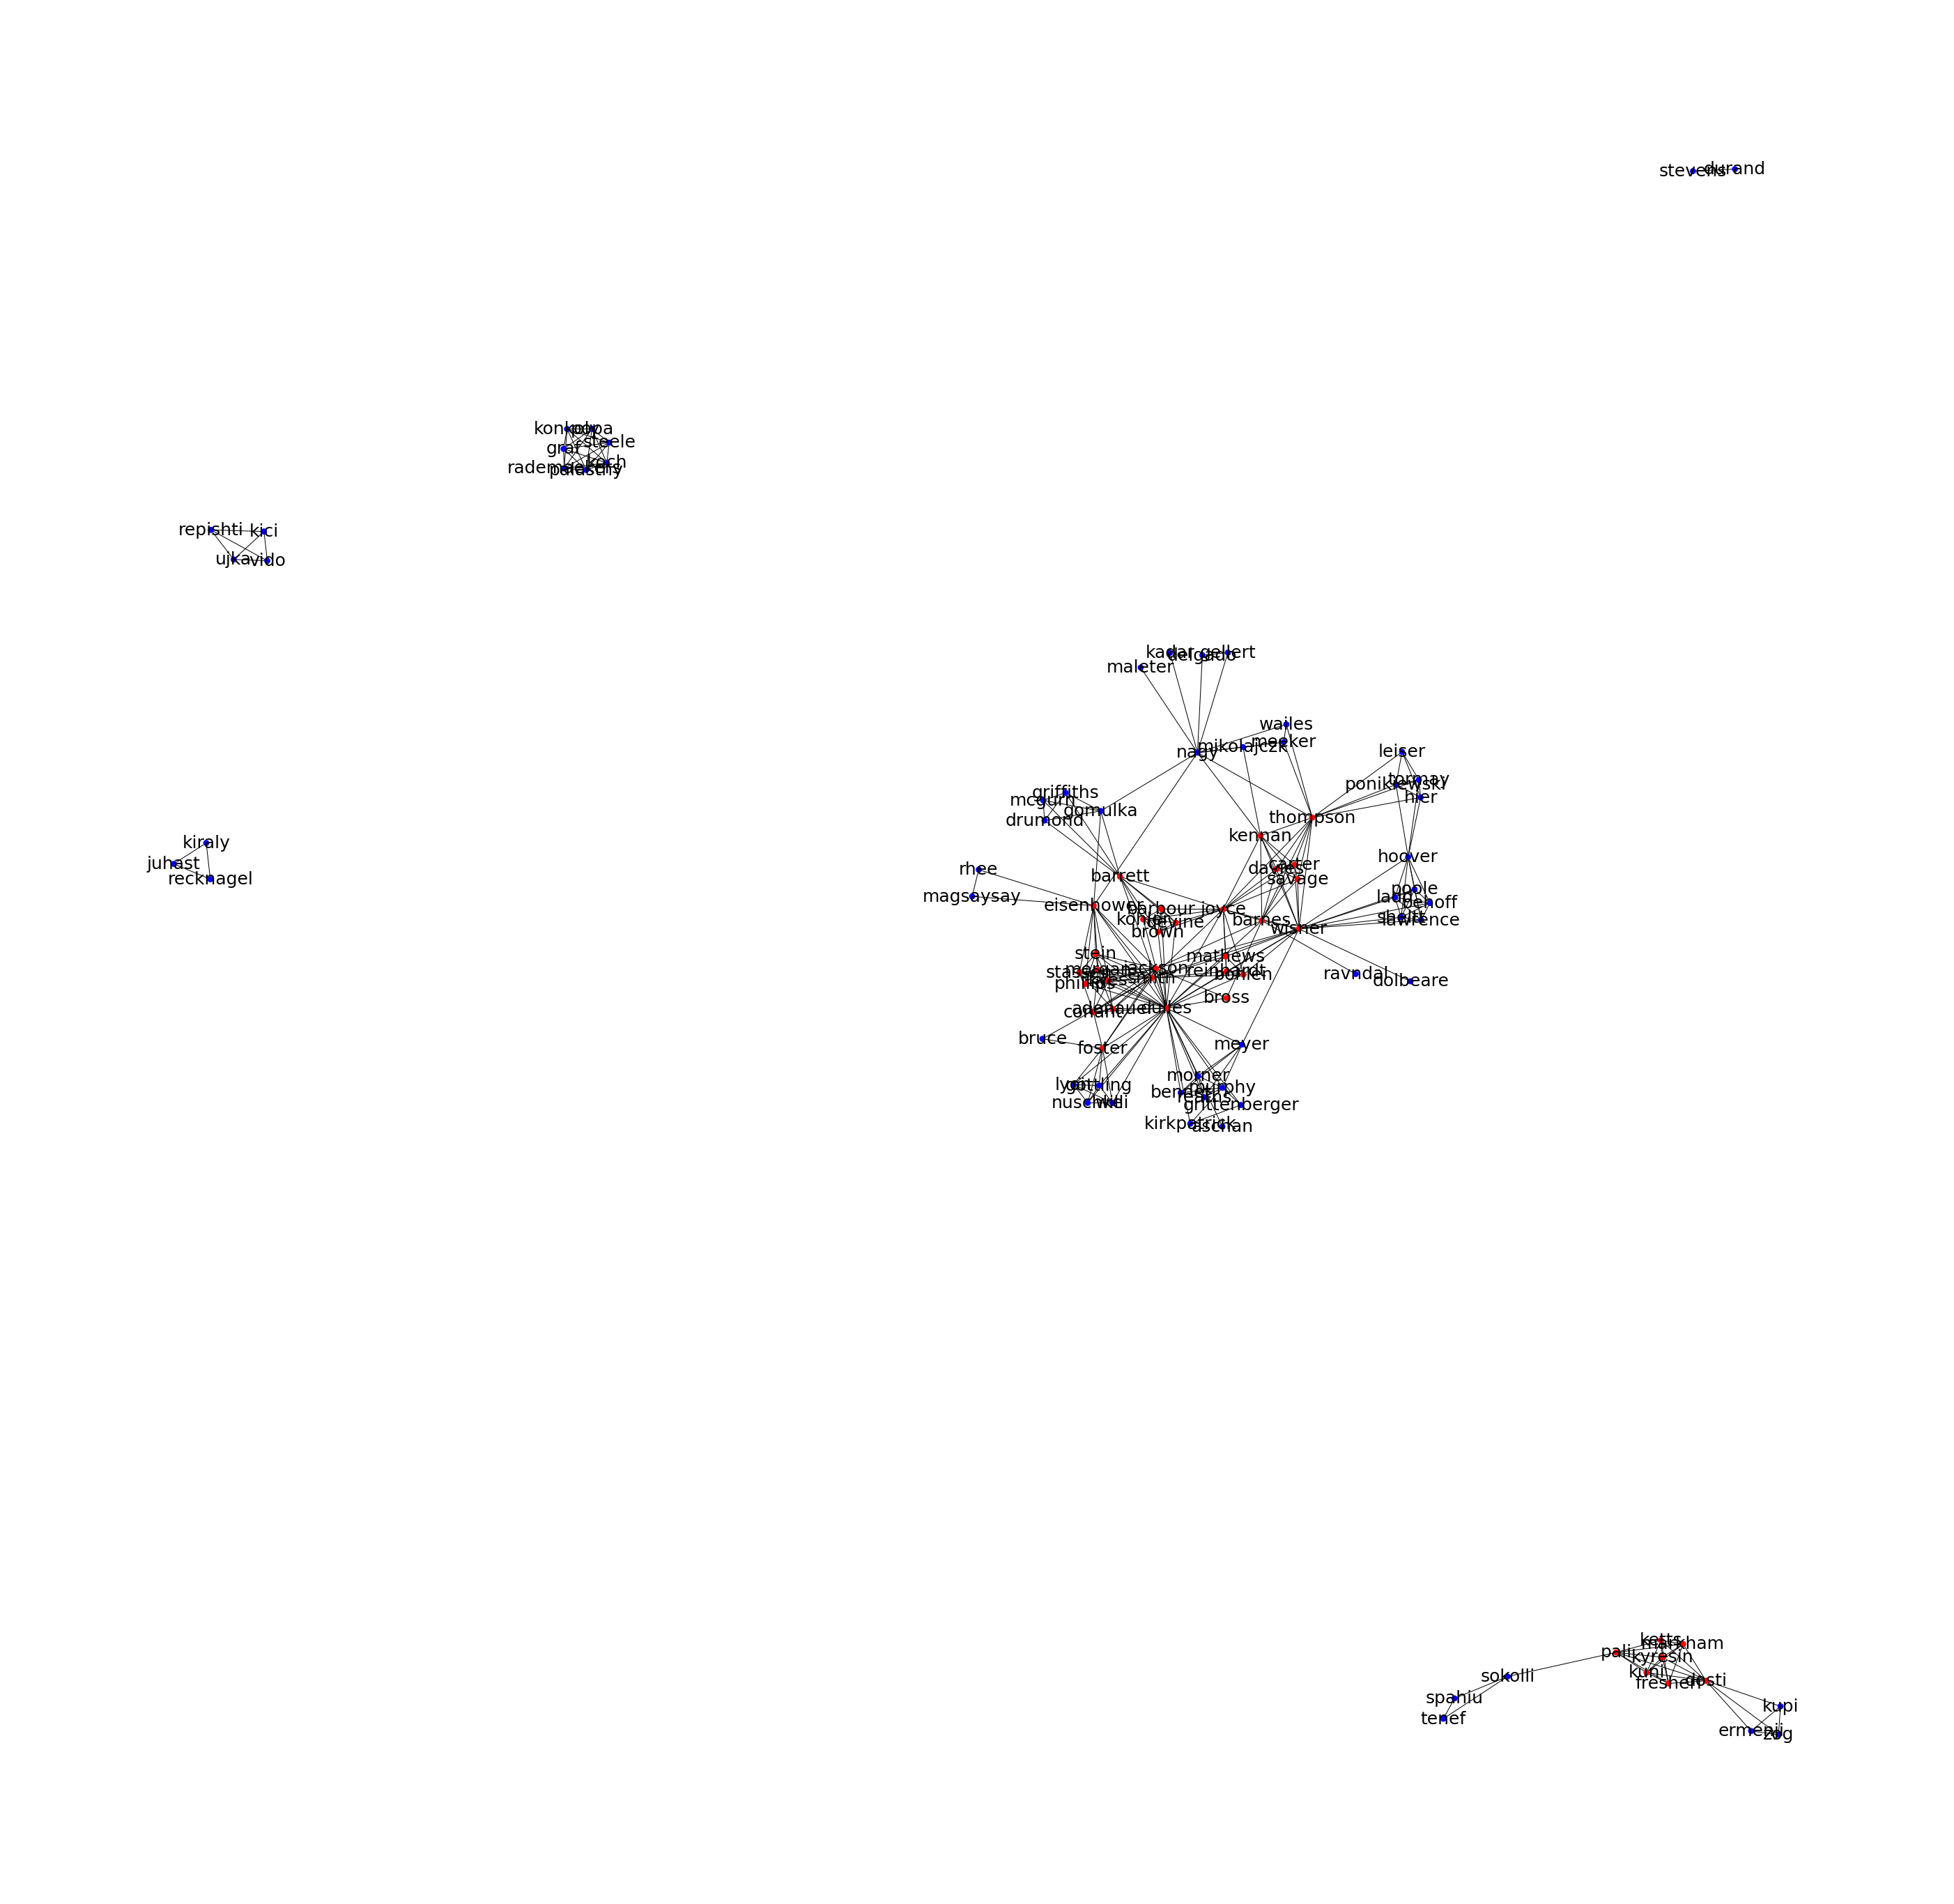

Degree Corrected SBM


In [77]:
fig, ax = plt.subplots(figsize=(50,50))

print("Standard SBM with the splitting into high and low degree nodes")
nx.draw(graph, position, ax=ax, with_labels = True, node_size=60, font_size=25, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()
print("Degree Corrected SBM")
nx.draw(graph, position, ax=ax, with_labels = True, node_size=60, font_size=25, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])

pl.show()